In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupKFold, GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge

# Import helperfunctions
from ML_functions import fun_load_settings, fun_load_data, fun_preprocessing, fun_fit_tuning
from ML_functions import fun_convert_time
from ML_functions import fun_scaled_neg_MAPE, fun_tuning_results, fun_scores
from ML_functions import plot_feature_weights

# Set the default optimization problem for the case of manual executing the script (choose either "TSP" or "CVRP")
default_optimization_problem = "TSP"

# Call the function to define optimization_problem based on how the notebook is executed
# If the notebook is run by the script "main.ipynb", load optimization_problem from "settings.json". Otherwise use the default optimization problem from above
optimization_problem = fun_load_settings(default_optimization_problem)

# Load data and start the time count for the script within the function fun_load_data
data, start_script = fun_load_data(optimization_problem)

# Do the train test split during the preprocessing
X_train, X_test, y_train, y_test, train_data = fun_preprocessing(data, train_size=0.8)

The notebook is executed directly. :)
Optimization Problem: 'TSP'


# **A. Instance-based models**
### **1. K-nearest Neighbor - KNN**
- RobustScaler did not perform

In [2]:
# Grid search cross validation with data scaling
pipe = Pipeline(steps=[("scaler", None), 
                       ("knn", KNeighborsRegressor())])

param_grid = {"scaler": [StandardScaler(), MinMaxScaler()], 
              "knn__n_neighbors": list(np.arange(start=7, stop=13))}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                           cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train["Instance ID"]), # Cross-validation with GroupKFold to keep instances together in one fold
                           scoring=fun_scaled_neg_MAPE, refit=False, verbose=True, n_jobs=-1)
tuning_details = fun_fit_tuning(search_method=grid_search, X_train=X_train, y_train=y_train, file_name=optimization_problem + "_KNN")

# View results of grid search cross validation
model_results_dict = fun_scores(model=grid_search, X_train=X_train, y_train=y_train)
model_results_dict.update(tuning_details)

# Create a dictionary to store the results
results_dict = {"KNN": model_results_dict}

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(search_method=grid_search, search_space=param_grid)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'Search type': 'GridSearchCV',
 'Parameter combinations': 12,
 'Total tuning time': '1m, 16s',
 'Total tuning fit time': '1s',
 'Total tuning prediction time': '4m, 22s'}

CV MAPE (scaled) train data:  23.7741 %


**Best model / parameter combination:**

{'knn__n_neighbors': 8, 'scaler': StandardScaler()}

**Cross validation scores of different parameter combinations:**

,scaler,n_neighbors,mean_test_score,converted_mean_fit_time
0,StandardScaler(),8,-0.237741,0s
1,StandardScaler(),7,-0.238124,0s
2,StandardScaler(),9,-0.238181,0s
3,StandardScaler(),10,-0.238625,0s
4,StandardScaler(),11,-0.238948,0s
5,StandardScaler(),12,-0.239573,0s
6,MinMaxScaler(),7,-0.249734,0s
7,MinMaxScaler(),8,-0.250346,0s
8,MinMaxScaler(),9,-0.250874,0s
9,MinMaxScaler(),10,-0.251698,0s


# **B. Linear Models**
### **1. Linear Regression**
- the model has no parameters. Thus, only cross-validation is conducted and no grid search cross-validation

CV MAPE (scaled) train data:  20.6429 %
CV RMSE (scaled) train data: 4.2858
CV computation time: 0s


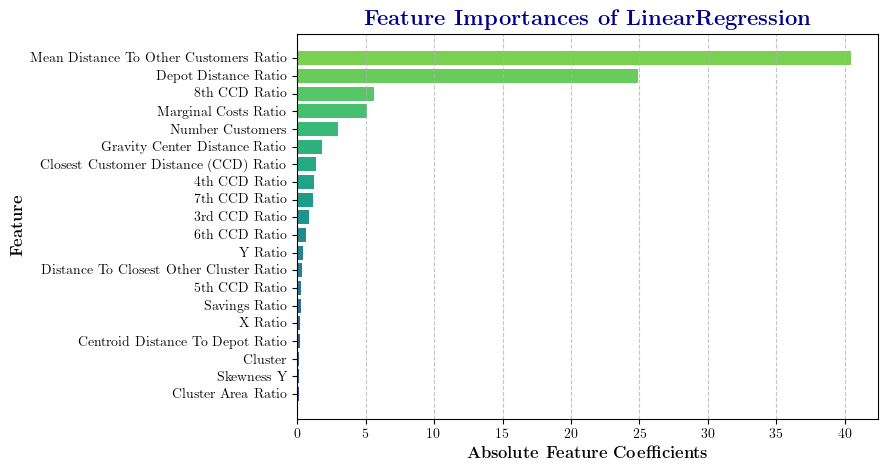

In [3]:
if (optimization_problem == "TSP"):
    
    # Create model
    lr = LinearRegression()

    # Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
    model_results_dict = fun_scores(lr, X_train, y_train, apply_scaling=True)

    # Save results to dictionary
    results_dict["Linear Regression"] = model_results_dict

    # Fit model on train set (default parameters) and show top 25 absolute feature weights
    plot_feature_weights(model=lr.fit(X_train, y_train), n_features=20)

else: print("This cell is only executed for the TSP!")

### **2. Rigde Regression (L2-Regularization)**
- higher alpha means higher regularization and lower model complexity (less overfitting); alpha=0 means linear regression

In [4]:
if (optimization_problem == "TSP"):

    # Grid search cross validation
    param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10]}

    grid_search = GridSearchCV(estimator=Ridge(solver="svd"), param_grid=param_grid, 
                            cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train["Instance ID"]),
                            scoring=fun_scaled_neg_MAPE, refit=False, verbose=True, n_jobs=-1)
    tuning_details = fun_fit_tuning(grid_search, X_train, y_train, file_name=optimization_problem + "_Ridge")

    # View results of grid search cross validation
    model_results_dict = fun_scores(grid_search, X_train, y_train)
    model_results_dict.update(tuning_details)

    # Save results to dictionary
    results_dict["Ridge Regression"] = model_results_dict

    # View grid search CV scores of all parameter combinations
    results_df = fun_tuning_results(grid_search, param_grid)

else: print("This cell is only executed for the TSP!")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'Search type': 'GridSearchCV',
 'Parameter combinations': 5,
 'Total tuning time': '1s',
 'Total tuning fit time': '4s',
 'Total tuning prediction time': '0s'}

CV MAPE (scaled) train data:  20.6427 %


**Best model / parameter combination:**

{'alpha': 1}

**Cross validation scores of different parameter combinations:**

,alpha,mean_test_score,converted_mean_fit_time
0,1.000,-0.206427,1s
1,0.100,-0.206428,1s
2,0.010,-0.206429,0s
3,0.001,-0.206429,0s
4,10.000,-0.206688,0s


### **3. Polynomial Regression**
#### **3.1 Polynomial Regression step by step**
**Apply binning (one hot encoding) for most important continuous features**

In [5]:
# Load most important features from script "b1_feature_selection.ipynb"
top_features = list(pd.read_csv(f"02_best_features/{optimization_problem}_top_features"))

# Example with only two bins per feature
discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform")
binned_features = discretizer.fit_transform(X_train[top_features])
binned_df = pd.DataFrame(binned_features, columns=[f"{col} binned" for col in top_features])
display(X_train[top_features].head(5))
display(binned_df.head(5))

,Marginal Costs Ratio,Gravity Center Distance Ratio,Centroid Distance To Depot Ratio,Depot Distance Ratio,Number Customers,7th CCD Ratio,8th CCD Ratio,Cluster Size,Savings Ratio,Mean Distance To Other Customers Ratio,Cluster,Total Costs,3rd CCD Ratio,Number Clusters,Cluster Area Ratio,X Std,Y Std,5th CCD Ratio,6th CCD Ratio,Distance To Closest Other Cluster Ratio
0,0.021584,1.442905,0.885295,0.320244,6,1.0,1.0,5,0.022796,1.175178,0,227.291186,1.045933,1,1.199907,21.621684,18.432836,1.211060,1.0,1.199919
1,2.365312,1.506247,1.573524,1.517015,6,1.0,1.0,1,2.161204,1.230834,-1,227.291186,1.253743,1,0.000465,21.621684,18.432836,1.211060,1.0,0.000403
2,0.176144,0.523415,0.885295,0.851033,6,1.0,1.0,5,0.186036,0.766016,0,227.291186,0.782974,1,1.199907,21.621684,18.432836,0.865881,1.0,1.199919
3,0.487476,0.217502,0.885295,0.954254,6,1.0,1.0,5,0.514850,0.718498,0,227.291186,0.735429,1,1.199907,21.621684,18.432836,0.713908,1.0,1.199919
4,0.096032,0.960795,0.885295,0.939229,6,1.0,1.0,5,0.101425,0.967599,0,227.291186,0.860173,1,1.199907,21.621684,18.432836,0.970327,1.0,1.199919


,Marginal Costs Ratio binned,Gravity Center Distance Ratio binned,Centroid Distance To Depot Ratio binned,Depot Distance Ratio binned,Number Customers binned,7th CCD Ratio binned,8th CCD Ratio binned,Cluster Size binned,Savings Ratio binned,Mean Distance To Other Customers Ratio binned,Cluster binned,Total Costs binned,3rd CCD Ratio binned,Number Clusters binned,Cluster Area Ratio binned,X Std binned,Y Std binned,5th CCD Ratio binned,6th CCD Ratio binned,Distance To Closest Other Cluster Ratio binned
0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,2.0
1,1.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,2.0
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,2.0
4,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,2.0


In [6]:
# Binning the continuous features to create a Data Frame with the bin affiliation for each feature (value between 0 and 29)
discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="uniform")
binned_features = discretizer.fit_transform(X_train[top_features])
binned_df = pd.DataFrame(binned_features, columns=[f"{col} binned" for col in top_features])

# One-Hot Encoding the binned features
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(binned_df)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(binned_df.columns), index=X_train.index)

# Combine with original data
X_train_onehot = pd.concat([X_train, one_hot_encoded_df], axis=1)
display(X_train_onehot.head())

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=LinearRegression(), X_train=X_train_onehot, y_train=y_train, apply_scaling=True)

# Save results to dictionary
results_dict["Linear Regression One hot"] = model_results_dict

,Instance ID,Number Customers,X Ratio,Y Ratio,X Depot,Y Depot,Depot Distance Ratio,Closest Customer Distance (CCD) Ratio,2nd CCD Ratio,3rd CCD Ratio,...,Distance To Closest Other Cluster Ratio binned_0.0,Distance To Closest Other Cluster Ratio binned_1.0,Distance To Closest Other Cluster Ratio binned_2.0,Distance To Closest Other Cluster Ratio binned_3.0,Distance To Closest Other Cluster Ratio binned_4.0,Distance To Closest Other Cluster Ratio binned_5.0,Distance To Closest Other Cluster Ratio binned_6.0,Distance To Closest Other Cluster Ratio binned_7.0,Distance To Closest Other Cluster Ratio binned_8.0,Distance To Closest Other Cluster Ratio binned_9.0
0,1,6,0.259951,1.437562,2.380844,66.016752,0.320244,1.262503,1.068225,1.045933,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,6,1.840139,1.174308,2.380844,66.016752,1.517015,1.419479,1.246244,1.253743,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,6,0.730341,0.844653,2.380844,66.016752,0.851033,0.386302,0.876273,0.782974,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,6,0.931506,0.869513,2.380844,66.016752,0.954254,0.386302,0.880063,0.735429,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,6,1.196190,1.647306,2.380844,66.016752,0.939229,1.267963,0.985226,0.860173,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


CV MAPE (scaled) train data:  20.2467 %
CV RMSE (scaled) train data: 4.2033
CV computation time: 1s


**Add Interactions and Polynomials**

In [7]:
# Generate interaction and polynomial features with all polynomial combinations of the features up to the specified degree (for all continuous features from above)
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=True)
poly.fit(X_train[top_features])
poly_df = pd.DataFrame(poly.transform(X_train[top_features]), index=X_train_onehot.index)

# Add polynomial features to the X_train_onehot data frame and the column "Total Costs" / "Total Bins" to scale the predicitons later
X_train_poly = pd.concat([X_train_onehot[[i for i in X_train_onehot.columns if i not in top_features]], poly_df], axis=1)
unit = "Costs" if ("Total Costs" in X_train.columns) else "Bins" # Feature name in TSP and CVRP: "Total Costs", Bin_Packing: "Total Bins"
X_train_poly = pd.concat([X_train_poly, X_train["Total " + unit]], axis=1)
X_train_poly.columns = X_train_poly.columns.astype(str)
display(X_train_poly.head())

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=LinearRegression(), X_train=X_train_poly, y_train=y_train, apply_scaling=True)

# Save results to dictionary
results_dict["Polynomial Regression"] = model_results_dict

,Instance ID,X Ratio,Y Ratio,X Depot,Y Depot,Closest Customer Distance (CCD) Ratio,2nd CCD Ratio,4th CCD Ratio,X Centroid,Y Centroid,...,1762,1763,1764,1765,1766,1767,1768,1769,1770,Total Costs
0,1,0.259951,1.437562,2.380844,66.016752,1.262503,1.068225,1.274274,37.629660,34.138395,...,1.466665,1.759880,1.211060,1.453174,1.743692e+00,1.0,1.199919,1.439807e+00,1.727652e+00,227.291186
1,1,1.840139,1.174308,2.380844,66.016752,1.419479,1.246244,1.131794,83.228495,41.537025,...,1.466665,0.000591,1.211060,0.000488,1.967249e-07,1.0,0.000403,1.624403e-07,6.546974e-11,227.291186
2,1,0.730341,0.844653,2.380844,66.016752,0.386302,0.876273,0.736554,37.629660,34.138395,...,0.749750,0.899640,0.865881,1.038988,1.246701e+00,1.0,1.199919,1.439807e+00,1.727652e+00,227.291186
3,1,0.931506,0.869513,2.380844,66.016752,0.386302,0.880063,0.758701,37.629660,34.138395,...,0.509664,0.611556,0.713908,0.856632,1.027889e+00,1.0,1.199919,1.439807e+00,1.727652e+00,227.291186
4,1,1.196190,1.647306,2.380844,66.016752,1.267963,0.985226,0.895617,37.629660,34.138395,...,0.941534,1.129764,0.970327,1.164314,1.397082e+00,1.0,1.199919,1.439807e+00,1.727652e+00,227.291186


CV MAPE (scaled) train data:  7.3472 %
CV RMSE (scaled) train data: 1.8699
CV computation time: 34s


#### **3.2 Polynomial Regression with Column Transformer as Preprocessor to create one-hot features, interactions and polynomial features**

In [8]:
# Define the preprocessing steps for continuous features
onehot_transformer = Pipeline(steps=[("binning", KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="uniform")),
                                     ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

poly_transformer = Pipeline(steps=[("poly", PolynomialFeatures(degree=3, interaction_only=False, include_bias=True))])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("onehot", onehot_transformer, top_features),
                                               ("poly", poly_transformer, top_features)],
                                               remainder="passthrough")

# Define the model pipeline
pipe = Pipeline(steps=[("preprocessor", preprocessor),
                       ("lr", LinearRegression())])

# Estimate model performance with cross-validation on the train set and get scores on test set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=pipe, X_train=X_train, y_train=y_train, apply_scaling=True)

CV MAPE (scaled) train data:  7.3413 %
CV RMSE (scaled) train data: 1.8643
CV computation time: 34s


**Plot Shapley Values and model predictions**

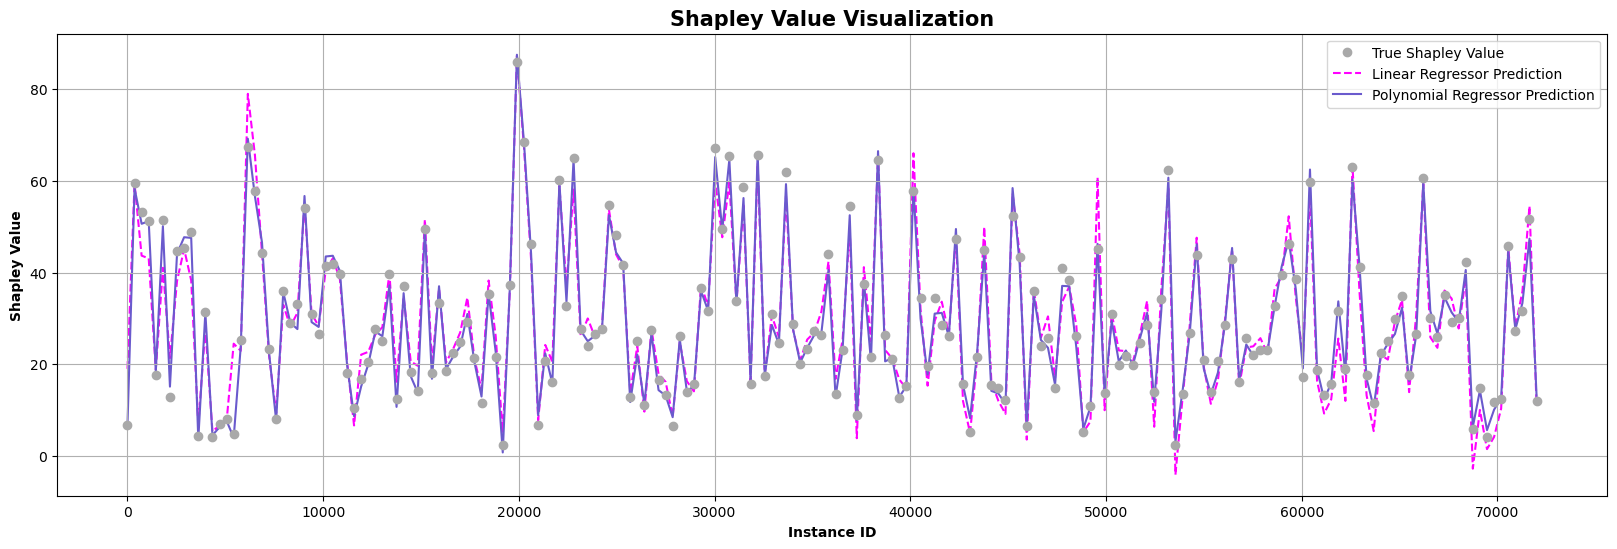

In [9]:
# Fit linear regressor make a prediction
lr = LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_train)

# Fit pipeline with polynomial predictor to make predictions
pipe.fit(X_train, y_train)
poly_reg_pred = pipe.predict(X_train)

# Select 200 instance IDs
line = np.linspace(0, len(X_train)-1, 200).astype("int")

# Create a plot with 200 True Shapley Values and the predictions from above
plt.figure(figsize=(20, 6))
plt.plot(line, [list(y_train)[i] for i in line], "o", c="darkgrey", label="True Shapley Value", zorder=2)
plt.plot(line, [list(lr_pred)[i] for i in line], "--", c="magenta", label="Linear Regressor Prediction", zorder=0)
plt.plot(line, [list(poly_reg_pred)[i] for i in line], "-", c="slateblue", label="Polynomial Regressor Prediction", zorder=1)
plt.xlabel("Instance ID", size=10, fontweight="bold")
plt.ylabel("Shapley Value", size=10, fontweight="bold")
plt.title("Shapley Value Visualization", size=15, fontweight="bold")
plt.legend(loc="upper right")
plt.grid()
plt.show()

# **C. Compare Results**

In [10]:
display(pd.DataFrame(results_dict).sort_values(by="MAPE", axis=1))
print("Total script computation time:", fun_convert_time(start=start_script, end=time.time()))

,Polynomial Regression,Linear Regression One hot,Ridge Regression,Linear Regression,KNN
MAPE,7.3472,20.2467,20.6427,20.6429,23.7741
RMSE,1.8699,4.2033,None,4.2858,None
CV computation time,34s,1s,None,0s,None
Search type,NaN,NaN,GridSearchCV,NaN,GridSearchCV
Parameter combinations,NaN,NaN,5,NaN,12
Total tuning time,NaN,NaN,1s,NaN,"1m, 16s"
Total tuning fit time,NaN,NaN,4s,NaN,1s
Total tuning prediction time,NaN,NaN,0s,NaN,"4m, 22s"


Total script computation time: 3m, 48s
